# Traffic sign classification using a convolutional neural network in MXNet

TODO: Add link to blog article when it's ready.
1. In this notebook we are going to classify German traffic signs using a convolutional neural network
2. We will learn about implementing convolution using MXNet.
3. The notebook assumes that you have a broad understanding of convolutional neural networks.

In [1]:
#some imports along with mxnet
%matplotlib inline
import mxnet as mx
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
import os
import scipy 
from scipy import ndimage

def read_images(path, n_samples, num_px=64):
    X = np.zeros((n_samples, num_px, num_px, 3))
    y = np.zeros((n_samples,))
    index = 0
    for _, _, files in os.walk(path):
        for pic_file in files:
            if index % 1000 == 0:
                print 'reading %d pics' % index
            image = np.array(ndimage.imread('train/'+pic_file, flatten=False))
            image = scipy.misc.imresize(image, size=(num_px,num_px))
            X[index] = image
            if pic_file.startswith('dog'):
                y[index] = 1
            else:
                y[index] = 0
            index += 1
    return X, y
train_files = []
for _, _, files in os.walk('train'):
    train_files.extend(files)
print 'train files: %d' % len(train_files)
X, y = read_images('train', len(train_files))

train files: 25000
reading 0 pics
reading 1000 pics
reading 2000 pics
reading 3000 pics
reading 4000 pics
reading 5000 pics
reading 6000 pics
reading 7000 pics
reading 8000 pics
reading 9000 pics
reading 10000 pics
reading 11000 pics
reading 12000 pics
reading 13000 pics
reading 14000 pics
reading 15000 pics
reading 16000 pics
reading 17000 pics
reading 18000 pics
reading 19000 pics
reading 20000 pics
reading 21000 pics
reading 22000 pics
reading 23000 pics
reading 24000 pics


In [5]:
import random
indexs = range(25000)
random.shuffle(indexs)
pos = int(25000 * 0.99)
X_train = X[indexs[:pos]]
X_valid = X[indexs[pos:]]
y_train = y[indexs[:pos]]
y_valid = y[indexs[pos:]]

In [6]:
train_dogs_percent = y_train.sum()/len(y_train)
train_cats_percent = 1.0 - train_dogs_percent
print 'train set: dogs: %f, cats: %f' % (train_dogs_percent, train_cats_percent)
valid_dogs_percent = y_valid.sum()/len(y_valid)
valid_cats_percent = 1.0 - valid_dogs_percent
print 'dev set: dogs: %f, cats: %f' % (valid_dogs_percent, valid_cats_percent)

train set: dogs: 0.499879, cats: 0.500121
dev set: dogs: 0.512000, cats: 0.488000


(499, 500, 3)


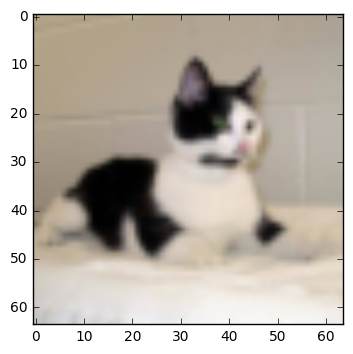

In [7]:
image = np.array(ndimage.imread('train/' + train_files[indexs[0]], flatten=False))
print image.shape
image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(image)

We are going to print few statistics to get a sense of what our data looks like. Labelling German traffic signs is a multi-class classification problem. There are, we'll see, 43 different classes of traffic sign in the dataset.

### Statistics about the data

In [8]:

# Number of training examples
n_train = len(X_train)

#Number of testing examples.
n_test = len(X_valid)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(y_train.shape)

('Number of training examples =', 24750)
('Number of testing examples =', 250)
('Image data shape =', (64, 64, 3))
('Number of classes =', 2)
(24750,)


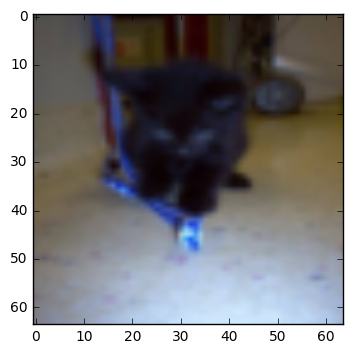

In [9]:
plt.imshow(X_train[20].astype('uint8'))

(24750, 3, 64, 64)


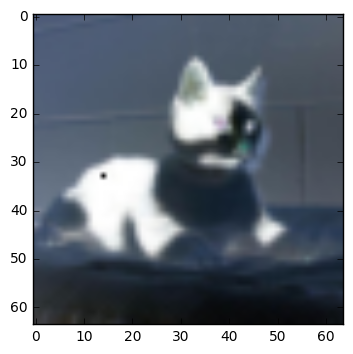

In [10]:
#change the image dimensioning from 32 X 32 X 3 to 3 X 32 X 32 for train

X_train_reshape = np.transpose(X_train, (0, 3, 1, 2))
plt.imshow(X_train_reshape[0].transpose((1,2,0)))
print(X_train_reshape.shape)

(250, 3, 64, 64)


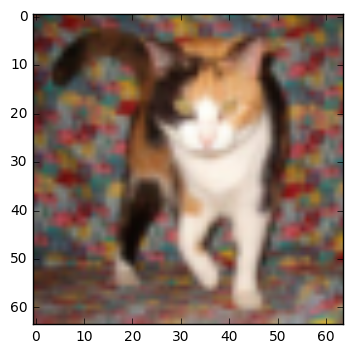

In [11]:
#change the image dimensioning from 32 X 32 X 3 to 3 X 32 X 32 for validation
X_valid_reshape = np.transpose(X_valid, (0, 3, 1, 2))
plt.imshow(X_valid_reshape[1].transpose((1,2,0)).astype('uint8'))
print(X_valid_reshape.shape)

### Building the deepnet

Now, enough of preparing our dataset. Let's actually code the neural network up. You'll note that there are some commented-out lines; I've left these in as artifacts from the development process—building a successful deep learning model is all about iteration and experimentation to find what works best. 
The neural code is actually small and simple, thanks to MXNet symbol API:

In [12]:

data = mx.symbol.Variable('data')
conv1 = mx.sym.Convolution(data=data, pad=(1,1), kernel=(3,3), num_filter=24, name="conv1")
relu1 = mx.sym.Activation(data=conv1, act_type="relu", name= "relu1")
pool1 = mx.sym.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool1")
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(3,3), num_filter=48, name="conv2", pad=(1,1))
relu2 = mx.sym.Activation(data=conv2, act_type="relu", name="relu2")
pool2 = mx.sym.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool2")

conv3 = mx.sym.Convolution(data=pool2, kernel=(5,5), num_filter=64, name="conv3")
relu3 = mx.sym.Activation(data=conv3, act_type="relu", name="relu3")
pool3 = mx.sym.Pooling(data=relu3, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool3")

#conv4 = mx.sym.Convolution(data=conv3, kernel=(5,5), num_filter=64, name="conv3")
#relu4 = mx.sym.Activation(data=conv4, act_type="relu", name="relu3")
#pool4 = mx.sym.Pooling(data=relu4, pool_type="max", kernel=(2,2), stride=(2,2),name="max_pool3")

# first fullc layer
flatten = mx.sym.Flatten(data=pool3)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=100, name="fc1")
relu3 = mx.sym.Activation(data=fc1, act_type="relu" , name="relu3")
# second fullc
fc2 = mx.sym.FullyConnected(data=relu3, num_hidden=2,name="final_fc")
# softmax loss
mynet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')


In [13]:
mynet.list_arguments()

['data',
 'conv1_weight',
 'conv1_bias',
 'conv2_weight',
 'conv2_bias',
 'conv3_weight',
 'conv3_bias',
 'fc1_weight',
 'fc1_bias',
 'final_fc_weight',
 'final_fc_bias',
 'softmax_label']

In [14]:
batch_size = 64
X_train_set_as_float = X_train_reshape.astype('float32')
#Noramilsing the image pixel to value between 0 to 1.0
X_train_set_norm = X_train_set_as_float[:] / 255.0;

#Noramilsing the image pixel to value between 0 to 1.0
X_validation_set_as_float = X_valid_reshape.astype('float32')
X_validation_set_norm = X_validation_set_as_float[:] / 255.0 ;


train_iter =mx.io.NDArrayIter(X_train_set_as_float, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_validation_set_as_float, y_valid, batch_size,shuffle=True)


print("train set : ", X_train_set_norm.shape)
print("validation set : ", X_validation_set_norm.shape)


print("y train set : ", y_train.shape)
print("y validation set :", y_valid.shape)


('train set : ', (24750, 3, 64, 64))
('validation set : ', (250, 3, 64, 64))
('y train set : ', (24750,))
('y validation set :', (250,))


### Training the deepnet

We will use adam optimizer to optimize the weights of our deep neural network.

In [ ]:
#Create Adam optimiser
adam = mx.optimizer.create('adam')

#Checkpointing (saving the model). Make sure there is folder named models exist
model_prefix = 'models/chkpt'
checkpoint = mx.callback.do_checkpoint(model_prefix)
                                       
#Loading the module API. Previously mxnet used feedforward (deprecated)                                       
model =  mx.mod.Module(
    context = mx.cpu(),     # use GPU 0 for training; if you don't have a gpu use mx.cpu()
    symbol = mynet,
    data_names=['data']
   )

#actually fit the model for 10 epochs. Can take 5 minutes                                      
model.fit(
    train_iter,
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 64),
    num_epoch = 20, 
    eval_metric='acc',
    optimizer = adam,
    epoch_end_callback=checkpoint
)

/usr/lib/python2.7/site-packages/mxnet/module/base_module.py:466: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  optimizer_params=optimizer_params)
INFO:root:Epoch[0] Batch [64]	Speed: 92.84 samples/sec	accuracy=0.507933
INFO:root:Epoch[0] Batch [128]	Speed: 92.39 samples/sec	accuracy=0.533691


In [18]:
acc = mx.metric.Accuracy()
model.score(val_iter,acc)
print(acc)


EvalMetric: {'accuracy': 0.7421875}


In [2]:
# Load the model from the checkpoint , we are loading the 10 epoch
model_prefix = 'models/chkpt'
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, 20)

# Assign the loaded parameters to the module
mod = mx.mod.Module(symbol=sym, context=mx.cpu())
mod.bind(for_training=False, data_shapes=[('data', (1,3,64,64))])
mod.set_params(arg_params, aux_params)

/usr/lib/python2.7/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [3]:
import os
import scipy 
import pandas as pd
from scipy import ndimage
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])
test_files = []
for _, _, files in os.walk('test'):
    test_files.extend(files)
ids = []
labels = []
index = 0
num_px = 64
for pic_file in test_files:
    if index % 1000 == 0:
        print 'Processed %d pics' % index
    index += 1
    ids.append(pic_file[:len(pic_file)-4])
    img = np.array(ndimage.imread('test/'+pic_file, flatten=False))
    img = scipy.misc.imresize(img, size=(num_px,num_px))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) #swaps axis to make it 3*32*32
    img = img[np.newaxis, :] 
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)
    labels.append(np.argmax(prob))
subb = pd.DataFrame({
        "id": ids, 
        "label": labels
    })
subb.to_csv('subbmission.csv', index=False)

Processed 0 pics
Processed 1000 pics
Processed 2000 pics
Processed 3000 pics
Processed 4000 pics
Processed 5000 pics
Processed 6000 pics
Processed 7000 pics
Processed 8000 pics
Processed 9000 pics
Processed 10000 pics
Processed 11000 pics
Processed 12000 pics


7002.jpg
cat


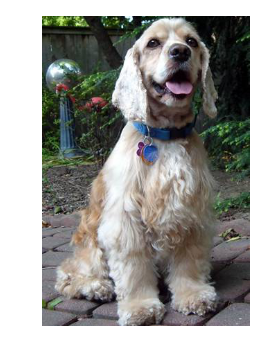

In [33]:
#Prediction for random traffic sign from internet
import random
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

#load the image , resizes it to 32*32 and converts it to 1*3*32*32 
def get_image(url, show=False):
    # download and show the image
    img =cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (64, 64))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) #swaps axis to make it 3*32*32
    #plt.imshow(img.transpose(1,2,0))
    #plt.axis('off')
    img = img[np.newaxis, :] # Add a extra axis to the image so it becomes 1*3*32*32
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    label = np.argmax(prob)
    print 'dog' if label == 1 else 'cat'

sample_pic = test_files[random.randint(0, len(test_files)-1)]
print sample_pic
predict('test/' + sample_pic)

7002.jpg
cat


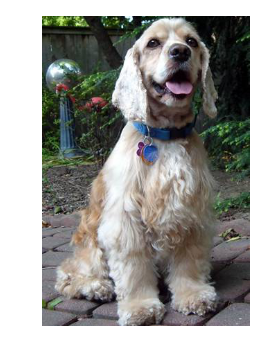

In [33]:
#Prediction for random traffic sign from internet
import random
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

#load the image , resizes it to 32*32 and converts it to 1*3*32*32 
def get_image(url, axis):
    # download and show the image
    img =cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    axis.imshow(img)
    axis.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (64, 64))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) #swaps axis to make it 3*32*32
    img = img[np.newaxis, :] # Add a extra axis to the image so it becomes 1*3*32*32
    return img

def predict(url, axis):
    img = get_image(url, axis)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    label = np.argmax(prob)
    print axis.set_title('%s: %s' % (url, 'dog' if label == 1 else 'cat'))

fig, axises = plt.subplot(4, 4)
for i in range(4):
    for j in range(4):
        sample_pic = test_files[random.randint(0, len(test_files)-1)]
        predict('test/' + sample_pic, axises[i, j])